In [2]:
import pandas as pd
import numpy as np
import imageio
import os
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import pickle
from scipy.spatial import distance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score
from datetime import datetime
from sklearn import metrics
import torch.optim as optim


## CNN AutoEncoder

In [3]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

    
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU()
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),   
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),   
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),    
            nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Helper Functions and Preprocessing

In [5]:


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = imageio.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images


def shuffle_data(data):
    random.seed(42)
    for i in range(len(data)-1, 0, -1):
        j = random.randint(0, i)
        data[i], data[j] = data[j], data[i]
    return data

def calculate_mean_std(images):
    transform = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor()
    ])

    transformed_images = []
    for img in images:
        img = Image.fromarray(img).convert('RGB')
        img_t = transform(img)
        transformed_images.append(img_t)

    images_stack = torch.stack(transformed_images)
    mean = torch.mean(images_stack, dim=[0, 2, 3])
    std = torch.std(images_stack, dim=[0, 2, 3])

    return mean, std


def preprocess_image(image_matrix,mean,std):
    # convert to PIL Image
    image = Image.fromarray(image_matrix)

    # define the transformation to resize and then normalize the image
    transform = transforms.Compose([
        transforms.Resize((96, 96)),       
        transforms.ToTensor(),              
        transforms.Normalize(mean=mean,  
                             std=std)
    ])
    image_tensor = transform(image)
    return image_tensor

# Load and preprocess the images
train_images = load_images_from_folder("STL-10/train_images")
train_images.extend(load_images_from_folder("STL-10/test_images"))

# uncomment the next line to include unlabeled images as well
# train_images.extend(load_images_from_folder("STL-10/unlabeled_images"))

train_images = shuffle_data(train_images)




/var/folders/rb/748331cd51g872n5yvlr7vrw0000gn/T/ipykernel_72846/1024273070.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(os.path.join(folder, filename))


In [6]:

mean,std  = calculate_mean_std(train_images)


In [7]:
mean

tensor([0.4470, 0.4397, 0.4056])

In [8]:
std

tensor([0.2605, 0.2566, 0.2705])

In [9]:
len(train_images)

13000

In [10]:
# preprocess all images
preprocessed_train_images = [preprocess_image(img,mean,std) for img in train_images]

In [104]:

# autoencoder = ConvAutoencoder()

# criterion = nn.MSELoss()
# optimizer = optim.Adam(autoencoder.parameters(), lr=.0005)

# image_tensor = torch.stack(preprocessed_train_images)
# dataset = TensorDataset(image_tensor, image_tensor)  # Input and target are the same for autoencoders
# dataloader = DataLoader(dataset, batch_size=100, shuffle=False)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# losses = []
# num_epochs = 50
# for epoch in range(num_epochs):
#     for imgs, _ in dataloader:
#         imgs = imgs.to(device)  # Move the data to the same device as the model

#         optimizer.zero_grad()
#         outputs = autoencoder(imgs)
#         loss = criterion(outputs, imgs)
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#     losses.append(loss.item())



Epoch [1/50], Loss: 0.7249
Epoch [2/50], Loss: 0.6316
Epoch [3/50], Loss: 0.6192
Epoch [4/50], Loss: 0.6065
Epoch [5/50], Loss: 0.5957
Epoch [6/50], Loss: 0.5843
Epoch [7/50], Loss: 0.5783
Epoch [8/50], Loss: 0.5744
Epoch [9/50], Loss: 0.5719
Epoch [10/50], Loss: 0.5692
Epoch [11/50], Loss: 0.5676
Epoch [12/50], Loss: 0.5661
Epoch [13/50], Loss: 0.5649
Epoch [14/50], Loss: 0.5639
Epoch [15/50], Loss: 0.5630
Epoch [16/50], Loss: 0.5623
Epoch [17/50], Loss: 0.5615
Epoch [18/50], Loss: 0.5607
Epoch [19/50], Loss: 0.5598
Epoch [20/50], Loss: 0.5590
Epoch [21/50], Loss: 0.5584
Epoch [22/50], Loss: 0.5578
Epoch [23/50], Loss: 0.5572
Epoch [24/50], Loss: 0.5567
Epoch [25/50], Loss: 0.5561
Epoch [26/50], Loss: 0.5555
Epoch [27/50], Loss: 0.5551
Epoch [28/50], Loss: 0.5546
Epoch [29/50], Loss: 0.5539
Epoch [30/50], Loss: 0.5534
Epoch [31/50], Loss: 0.5527
Epoch [32/50], Loss: 0.5520
Epoch [33/50], Loss: 0.5512
Epoch [34/50], Loss: 0.5506
Epoch [35/50], Loss: 0.5499
Epoch [36/50], Loss: 0.5498
E

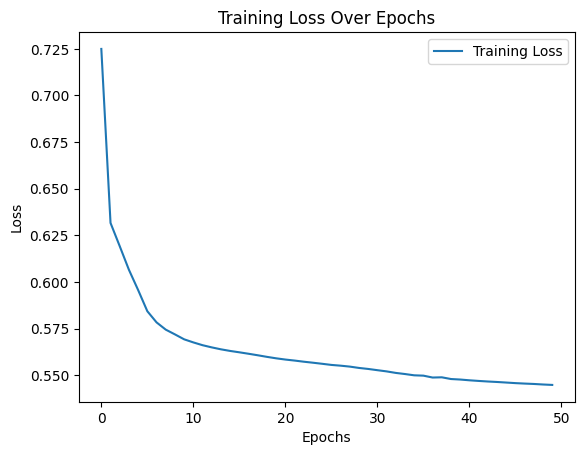

In [105]:
import matplotlib.pyplot as plt


plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [11]:

autoencoder = ConvAutoencoder()
autoencoder.load_state_dict(torch.load('app/src/model/autoencoder_state_dict.pth'))
       
# autoencoder.load_state_dict(torch.load('path_to_trained_model.pth'))
autoencoder.eval()  # Set the model to evaluation mode

# convert list of tensors to a single tensor
image_tensor = torch.stack(preprocessed_train_images)

# create a dataset and dataloader for batch processing
dataset = TensorDataset(image_tensor)
dataloader = DataLoader(dataset, batch_size=100)  

# process images in batches
encoded_batches = []
for batch in dataloader:
    imgs, = batch
    encoded_imgs = autoencoder.encoder(imgs)
    encoded_batches.append(encoded_imgs)



In [63]:
# torch.save(autoencoder.state_dict(), 'app/src/model/autoencoder_state_dict.pth')

In [12]:
# flatten each encoded image
encoded_images_flat = [encoded_img.view(-1).detach() for batch in encoded_batches for encoded_img in batch]
# convert to np array where each row is an encoded image
encoded_images_np = np.array([img.numpy() for img in encoded_images_flat])



In [25]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import pandas as pd
from datetime import datetime
from sklearn.metrics import make_scorer

param_grid = {
    'n_clusters': [10,25,50,100],
    'init': ['k-means++'],
    'n_init': [10],
    'max_iter': [300]
}

kmeans = KMeans()

# set up GridSearchCV 
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=5)

# fit the grid search to the data
grid_search.fit(encoded_images_np)

# convert the results to a pandas DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# get the current timestamp to use in the file name
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# define the file name with the timestamp
file_name = f'grid_search_results_{timestamp}.xlsx'

# export to Excel
results_df.to_excel(file_name, index=False)

In [26]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,19.265453,1.388176,0.005941,0.000117,k-means++,300,10,10,"{'init': 'k-means++', 'max_iter': 300, 'n_clus...",-2743.462891,-2764.863281,-2756.523438,-2773.112793,-2710.236328,-2749.639746,22.004127,4
1,41.138695,1.698679,0.009862,0.004476,k-means++,300,25,10,"{'init': 'k-means++', 'max_iter': 300, 'n_clus...",-2571.083740,-2583.732422,-2569.687012,-2600.921143,-2533.092285,-2571.703320,22.332227,3
2,72.037883,1.840392,0.009699,0.002531,k-means++,300,50,10,"{'init': 'k-means++', 'max_iter': 300, 'n_clus...",-2464.900391,-2473.853516,-2467.883057,-2502.422119,-2443.281738,-2470.468164,19.022621,2
3,147.506941,14.304350,0.016154,0.003246,k-means++,300,100,10,"{'init': 'k-means++', 'max_iter': 300, 'n_clus...",-2393.642090,-2407.274902,-2393.659180,-2429.663818,-2368.030273,-2398.454053,20.117699,1


In [79]:
grid_search.best_estimator_

KMeans(n_clusters=10, n_init=10)

### Benchmark Kmeans No encoding

In [18]:

flattened_images = [img_tensor.view(-1).numpy() for img_tensor in preprocessed_train_images]


flattened_images_np = np.array(flattened_images)
kmeans = KMeans(n_clusters=10)

clusters = kmeans.fit_predict(flattened_images_np) 


/Users/mitchleahy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.043141283

In [21]:
inertia = kmeans.inertia_
calinski_harabasz = metrics.calinski_harabasz_score(flattened_images_np, clusters)
davies_bouldin = metrics.davies_bouldin_score(flattened_images_np, clusters)
score = silhouette_score(flattened_images_np, clusters)

print(f"Silhuoetee score {score}")
print(f"Inertia: {inertia}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")
print(f"Davies-Bouldin Index: {davies_bouldin}")

Inertia: 251871728.0
Calinski-Harabasz Index: 578.9925998169226
Davies-Bouldin Index: 3.087361878167752


In [19]:

with open('app/src/model/vinilla_kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

### Kmeans using encoded data

In [28]:

kmeans = KMeans(n_clusters=10,n_init=10,max_iter=300,init='k-means++')

clusters = kmeans.fit_predict(encoded_images_np) 



In [29]:
# with open('app/src/model/kmeans_model.pkl', 'wb') as file:
#     pickle.dump(kmeans, file)
# # send this to a txt file
# np.savetxt("app/src/data/clusters.txt", clusters, fmt='%d')
# read in this text file

In [30]:
inertia = kmeans.inertia_
calinski_harabasz = metrics.calinski_harabasz_score(encoded_images_np, clusters)
davies_bouldin = metrics.davies_bouldin_score(encoded_images_np, clusters)
score = silhouette_score(encoded_images_np, clusters)

print(f"Silhuoetee score {score}")
print(f"Inertia: {inertia}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")
print(f"Davies-Bouldin Index: {davies_bouldin}")

Silhuoetee score 0.058991700410842896
Inertia: 1090040192.0
Calinski-Harabasz Index: 667.6293480722495
Davies-Bouldin Index: 2.807296298721107


In [17]:
clusters = np.loadtxt("app/src/data/clusters.txt", dtype=int)

In [18]:
251871728.0-1090009216.0

-838137488.0

In [19]:
# # Preprocess the new image
image = load_images_from_folder('STL-10/sample_input_images')[0]
new_image_tensor = preprocess_image(image,mean,std)


encoded_new_image = autoencoder.encoder(new_image_tensor) 
encoded_new_image_flat = encoded_new_image.view(-1).detach().numpy().astype(np.float32).reshape(1,-1)  # Flatten and convert to numpy

prediction = kmeans.predict(encoded_new_image_flat)
## get all data points in each cluster
input_image_cluster = prediction[0]

# find all indexes of data points in input_image_cluster 
input_image_cluster_matches = np.where(clusters == input_image_cluster)[0]
#filter train_images 
train_images_filtered = [train_images[i] for i in input_image_cluster_matches]
# filter preprocess images
preprocessed_train_images_filtered = np.array([encoded_images_np[i] for i in input_image_cluster_matches])


encoded_new_image_flat  = encoded_new_image_flat.ravel()
# calculate Euclidean distances
distances = [distance.euclidean(encoded_new_image_flat, img_flat) 
             for img_flat in preprocessed_train_images_filtered]
closest_indices = np.argsort(distances)[:2]

# retrieve the two closest images
closest_images = [train_images_filtered[i] for i in closest_indices]

/var/folders/rb/748331cd51g872n5yvlr7vrw0000gn/T/ipykernel_72846/1024273070.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(os.path.join(folder, filename))


In [20]:
input_image_cluster

0

/var/folders/rb/748331cd51g872n5yvlr7vrw0000gn/T/ipykernel_72846/1024273070.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(os.path.join(folder, filename))


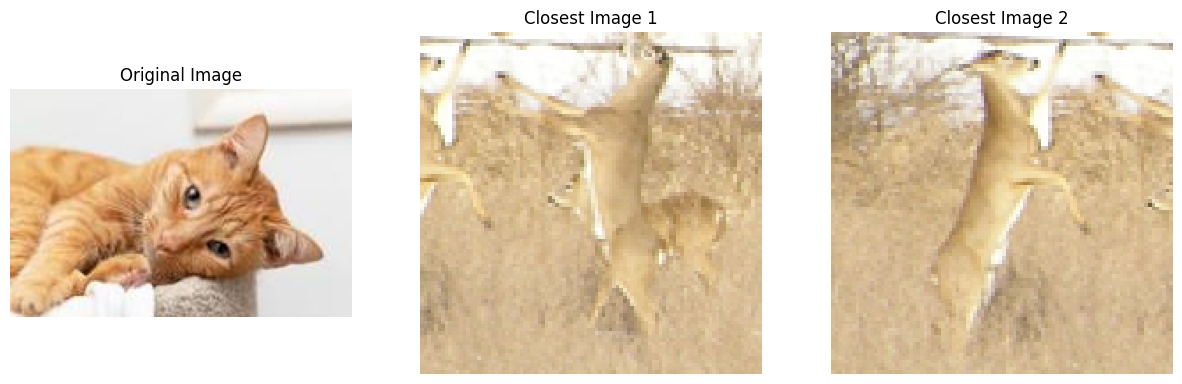

In [21]:


# load the initial image
image = load_images_from_folder('STL-10/sample_input_images')[0]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))


axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('Original Image')


for i in range(2):
    axs[i + 1].imshow(closest_images[i])
    axs[i + 1].axis('off')
    axs[i + 1].set_title(f'Closest Image {i+1}')


plt.show()


Text(0.5, 1.0, 'Reconstructed Image')

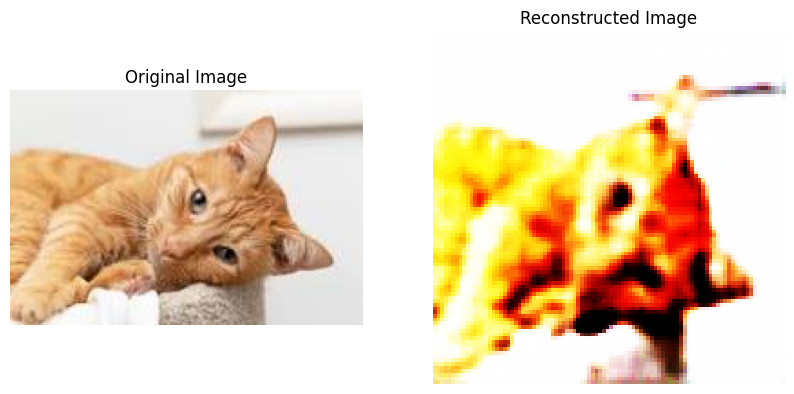

In [22]:

encoded_img = autoencoder.encoder(new_image_tensor)
reconstructed_img = autoencoder.decoder(encoded_img)

image_np = reconstructed_img.detach().cpu().numpy()

# Reshape/Reorder dimensions to (Height, Width, Channels)
image_np = np.transpose(image_np, (1, 2, 0))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display original image
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('Original Image')

# Display reconstructed image
axs[1].imshow(image_np)
axs[1].axis('off')
axs[1].set_title('Reconstructed Image')

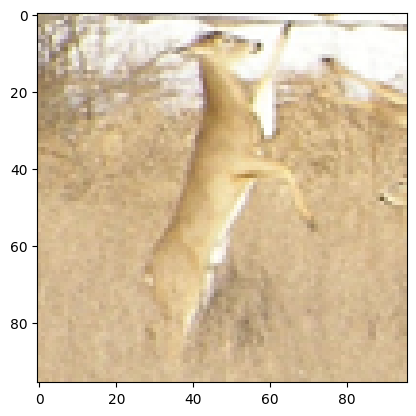

In [36]:
demo=preprocess_image(image,mean,std).detach().cpu().numpy()
image_demo = np.transpose(demo, (1, 2, 0))

plt.imshow(closest_images[1])